In [1]:
from pathlib import Path
import warnings
import time
import gc

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure display
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

# Directories
project_root = (Path.cwd() / '..').resolve()
data_dir = project_root / 'data' / 'processed'
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

print(f'✓ Project root: {project_root}')
print(f'✓ Data directory: {data_dir}')
print(f'✓ Models will be saved to: {models_dir}')

✓ Project root: /home/sakana/Code/DS-RS
✓ Data directory: /home/sakana/Code/DS-RS/data/processed
✓ Models will be saved to: /home/sakana/Code/DS-RS/models


## 2. Load Cleaned Dataset

In [2]:
# Load cleaned jobs dataset
print('Loading cleaned dataset...')
df = pd.read_parquet(data_dir / 'clean_jobs.parquet')

# Create clean_text column by combining title, description, and skills
print('Creating clean_text column...')
df['clean_text'] = (
    df['title_clean'].fillna('') + ' ' +
    df['description_clean'].fillna('') + ' ' +
    df['skills_desc_clean'].fillna('')
).str.strip()

print(f'\n✓ Dataset loaded: {len(df):,} jobs')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB')
print(f'\nKey columns for vectorization:')
print(f'  - clean_text: {df["clean_text"].notna().sum():,} ({df["clean_text"].notna().mean()*100:.1f}%)')
print(f'  - skills: {df["skills"].notna().sum():,} ({df["skills"].notna().mean()*100:.1f}%)')
print(f'  - industries: {df["industries"].notna().sum():,} ({df["industries"].notna().mean()*100:.1f}%)')

# Sample job
print(f'\nSample job (first row):')
sample_job = df.iloc[0]
print(f'Title: {sample_job["title"]}')
print(f'Skills: {sample_job["skills"][:100]}...' if sample_job["skills"] else 'Skills: N/A')
print(f'Industry: {sample_job["industries"][:50]}...' if sample_job["industries"] else 'Industry: N/A')
print(f'Clean text length: {len(sample_job["clean_text"])} chars')

Loading cleaned dataset...
Creating clean_text column...
Creating clean_text column...

✓ Dataset loaded: 123,842 jobs

✓ Dataset loaded: 123,842 jobs
Memory usage: 2.52 GB

Key columns for vectorization:
  - clean_text: 123,842 (100.0%)
  - skills: 122,090 (98.6%)
  - industries: 122,308 (98.8%)

Sample job (first row):
Title: Marketing Coordinator
Skills: Marketing, Sales...
Industry: Real Estate...
Clean text length: 2747 chars
Memory usage: 2.52 GB

Key columns for vectorization:
  - clean_text: 123,842 (100.0%)
  - skills: 122,090 (98.6%)
  - industries: 122,308 (98.8%)

Sample job (first row):
Title: Marketing Coordinator
Skills: Marketing, Sales...
Industry: Real Estate...
Clean text length: 2747 chars


In [3]:
# Create sample for faster experimentation (50k jobs for production)
SAMPLE_SIZE = 50000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).copy()
print(f'Working with sample of {len(df_sample):,} jobs for production deployment')

# Prepare text column
texts = df_sample['clean_text'].fillna('').values
print(f'\nText corpus: {len(texts):,} documents')
print(f'Avg length: {np.mean([len(t) for t in texts]):.0f} chars')

Working with sample of 50,000 jobs for production deployment

Text corpus: 50,000 documents
Avg length: 3695 chars


## 3. TF-IDF Baseline

Implement traditional TF-IDF vectorization as baseline.

In [4]:
# TF-IDF Vectorization
print('Fitting TF-IDF vectorizer...')
start_time = time.time()

tfidf = TfidfVectorizer(
    max_features=5000,      # Limit vocabulary size
    ngram_range=(1, 2),     # Unigrams + bigrams
    min_df=5,               # Ignore terms appearing in < 5 docs
    max_df=0.8,             # Ignore terms appearing in > 80% docs
    stop_words='english',   # Remove English stopwords
    lowercase=True,
    dtype=np.float32        # Use float32 for memory efficiency
)

tfidf_matrix = tfidf.fit_transform(texts)
tfidf_time = time.time() - start_time

print(f'\n✓ TF-IDF completed in {tfidf_time:.2f}s')
print(f'Matrix shape: {tfidf_matrix.shape}')
print(f'Vocabulary size: {len(tfidf.vocabulary_):,} terms')
print(f'Matrix sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%')
print(f'Memory usage: {tfidf_matrix.data.nbytes / 1024**2:.1f} MB')

Fitting TF-IDF vectorizer...

✓ TF-IDF completed in 28.94s
Matrix shape: (50000, 5000)
Vocabulary size: 5,000 terms
Matrix sparsity: 95.17%
Memory usage: 46.0 MB

✓ TF-IDF completed in 28.94s
Matrix shape: (50000, 5000)
Vocabulary size: 5,000 terms
Matrix sparsity: 95.17%
Memory usage: 46.0 MB


In [6]:
# Test TF-IDF similarity search
def search_tfidf(query_text, top_k=5):
    """Search for similar jobs using TF-IDF."""
    # Transform query
    query_vec = tfidf.transform([query_text])
    
    # Compute similarities
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    # Get top-K indices
    top_indices = similarities.argsort()[::-1][:top_k]
    
    # Return results
    results = []
    for idx in top_indices:
        results.append({
            'index': df_sample.index[idx],
            'title': df_sample.iloc[idx]['title'],
            'skills': df_sample.iloc[idx]['skills'],
            'industry': df_sample.iloc[idx]['industries'],
            'similarity': similarities[idx]
        })
    return results

# Test with sample query
query = "Python software engineer with machine learning experience"
print(f'Query: "{query}"\n')

start_time = time.time()
results = search_tfidf(query, top_k=5)
search_time = time.time() - start_time

print(f'Search completed in {search_time*1000:.1f}ms\n')
print('Top 5 Results:')
for i, result in enumerate(results, 1):
    print(f"\n{i}. {result['title']}")
    print(f"   Similarity: {result['similarity']:.3f}")
    print(f"   Skills: {result['skills'][:100]}..." if result['skills'] else "   Skills: N/A")
    print(f"   Industry: {result['industry'][:50]}..." if result['industry'] else "   Industry: N/A")

Query: "Python software engineer with machine learning experience"

Search completed in 128.0ms

Top 5 Results:

1. Machine Learning Engineer - Remote
   Similarity: 0.621
   Skills: Information Technology...
   Industry: Information Services, Technology, Information and ...

2. Senior Back-End Software Engineer (Machine Learning Emphasis)
   Similarity: 0.607
   Skills: Engineering...
   Industry: Software Development...

3. Lead Python Software Engineer
   Similarity: 0.602
   Skills: Engineering, Information Technology...
   Industry: IT Services and IT Consulting...

4. Lead Machine Learning Engineer
   Similarity: 0.587
   Skills: Engineering, Information Technology...
   Industry: Software Development...

5.  Sr GenAI / Machine Learning Engineer
   Similarity: 0.578
   Skills: Engineering...
   Industry: Software Development...


## 4. Sentence-Transformers (MiniLM)

Test modern embedding model for semantic understanding.

In [7]:
# Install sentence-transformers if needed
try:
    from sentence_transformers import SentenceTransformer
    print('✓ sentence-transformers already installed')
except ImportError:
    print('Installing sentence-transformers...')
    import sys
    !{sys.executable} -m pip install -q sentence-transformers
    from sentence_transformers import SentenceTransformer
    print('✓ sentence-transformers installed')

✓ sentence-transformers already installed


In [8]:
# Load MiniLM model
print('Loading sentence-transformers model...')
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
start_time = time.time()

model = SentenceTransformer(model_name)
load_time = time.time() - start_time

print(f'✓ Model loaded in {load_time:.2f}s')
print(f'Model: {model_name}')
print(f'Embedding dimension: {model.get_sentence_embedding_dimension()}')
print(f'Max sequence length: {model.max_seq_length}')

Loading sentence-transformers model...
✓ Model loaded in 7.76s
Model: sentence-transformers/all-MiniLM-L6-v2
Embedding dimension: 384
Max sequence length: 256
✓ Model loaded in 7.76s
Model: sentence-transformers/all-MiniLM-L6-v2
Embedding dimension: 384
Max sequence length: 256


In [9]:
# Encode texts with MiniLM
print(f'Encoding {len(texts):,} documents with MiniLM...')
start_time = time.time()

# Encode in batches for efficiency
embeddings = model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # L2 normalization for cosine similarity
)

encode_time = time.time() - start_time

print(f'\n✓ Encoding completed in {encode_time:.2f}s')
print(f'Embeddings shape: {embeddings.shape}')
print(f'Memory usage: {embeddings.nbytes / 1024**2:.1f} MB')
print(f'Avg encoding speed: {len(texts)/encode_time:.0f} docs/sec')

Encoding 50,000 documents with MiniLM...


Batches: 100%|██████████| 1563/1563 [03:05<00:00,  8.45it/s]




✓ Encoding completed in 187.62s
Embeddings shape: (50000, 384)
Memory usage: 73.2 MB
Avg encoding speed: 266 docs/sec


In [10]:
# Test MiniLM similarity search
def search_minilm(query_text, top_k=5):
    """Search for similar jobs using MiniLM embeddings."""
    # Encode query
    query_emb = model.encode([query_text], normalize_embeddings=True)
    
    # Compute similarities (dot product since normalized)
    similarities = np.dot(embeddings, query_emb.T).flatten()
    
    # Get top-K indices
    top_indices = similarities.argsort()[::-1][:top_k]
    
    # Return results
    results = []
    for idx in top_indices:
        results.append({
            'index': df_sample.index[idx],
            'title': df_sample.iloc[idx]['title'],
            'skills': df_sample.iloc[idx]['skills'],
            'industry': df_sample.iloc[idx]['industries'],
            'similarity': similarities[idx]
        })
    return results

# Test with same query
print(f'Query: "{query}"\n')

start_time = time.time()
results_minilm = search_minilm(query, top_k=5)
search_time_minilm = time.time() - start_time

print(f'Search completed in {search_time_minilm*1000:.1f}ms\n')
print('Top 5 Results (MiniLM):')
for i, result in enumerate(results_minilm, 1):
    print(f"\n{i}. {result['title']}")
    print(f"   Similarity: {result['similarity']:.3f}")
    print(f"   Skills: {result['skills'][:100]}..." if result['skills'] else "   Skills: N/A")
    print(f"   Industry: {result['industry'][:50]}..." if result['industry'] else "   Industry: N/A")

Query: "Python software engineer with machine learning experience"

Search completed in 46.7ms

Top 5 Results (MiniLM):

1. Python Developer
   Similarity: 0.703
   Skills: Engineering, Information Technology...
   Industry: Software Development...

2. Lead Python Software Engineer
   Similarity: 0.694
   Skills: Engineering, Information Technology...
   Industry: IT Services and IT Consulting...

3. Python Developer
   Similarity: 0.690
   Skills: Information Technology...
   Industry: IT Services and IT Consulting...

4. Python Developer
   Similarity: 0.674
   Skills: Engineering, Information Technology...
   Industry: Technology, Information and Internet...

5. Python Developer with Django, Flask
   Similarity: 0.671
   Skills: Engineering, Information Technology...
   Industry: IT Services and IT Consulting...


## 5. Comparison: TF-IDF vs MiniLM

In [11]:
# Benchmark comparison
comparison = pd.DataFrame([
    {
        'Method': 'TF-IDF',
        'Training Time (s)': tfidf_time,
        'Vector Dim': tfidf_matrix.shape[1],
        'Memory (MB)': tfidf_matrix.data.nbytes / 1024**2,
        'Search Speed (ms)': search_time * 1000,
        'Sparse': 'Yes'
    },
    {
        'Method': 'MiniLM',
        'Training Time (s)': encode_time,
        'Vector Dim': embeddings.shape[1],
        'Memory (MB)': embeddings.nbytes / 1024**2,
        'Search Speed (ms)': search_time_minilm * 1000,
        'Sparse': 'No'
    }
])

print('\n' + '='*70)
print('BENCHMARK COMPARISON: TF-IDF vs MiniLM')
print('='*70)
print(comparison.to_string(index=False))
print('='*70)


BENCHMARK COMPARISON: TF-IDF vs MiniLM
Method  Training Time (s)  Vector Dim  Memory (MB)  Search Speed (ms) Sparse
TF-IDF          28.942852        5000    46.043125         128.031254    Yes
MiniLM         187.623438         384    73.242188          46.742916     No


✓ Saved comparison plot to images/model_comparison.png


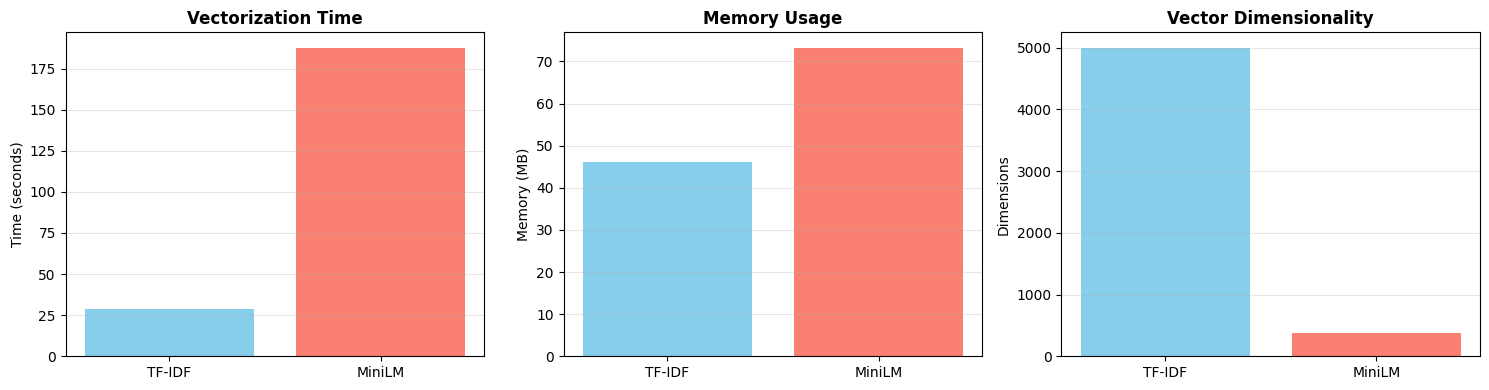

In [12]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training time
axes[0].bar(['TF-IDF', 'MiniLM'], [tfidf_time, encode_time], color=['skyblue', 'salmon'])
axes[0].set_ylabel('Time (seconds)', fontsize=10)
axes[0].set_title('Vectorization Time', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Memory usage
tfidf_mem = tfidf_matrix.data.nbytes / 1024**2
minilm_mem = embeddings.nbytes / 1024**2
axes[1].bar(['TF-IDF', 'MiniLM'], [tfidf_mem, minilm_mem], color=['skyblue', 'salmon'])
axes[1].set_ylabel('Memory (MB)', fontsize=10)
axes[1].set_title('Memory Usage', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Vector dimensions
axes[2].bar(['TF-IDF', 'MiniLM'], [tfidf_matrix.shape[1], embeddings.shape[1]], color=['skyblue', 'salmon'])
axes[2].set_ylabel('Dimensions', fontsize=10)
axes[2].set_title('Vector Dimensionality', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'images' / 'model_comparison.png', dpi=150, bbox_inches='tight')
print('✓ Saved comparison plot to images/model_comparison.png')
plt.show()

## 6. Quality Evaluation

Test with multiple queries to assess recommendation quality.

In [13]:
# Test queries
test_queries = [
    "Python backend developer with API experience",
    "Registered nurse with emergency room experience",
    "Sales manager with B2B software experience",
    "Data scientist machine learning deep learning",
    "Project manager agile scrum certification"
]

print('Testing recommendation quality...\n')

for i, q in enumerate(test_queries, 1):
    print(f'\n{"="*70}')
    print(f'Query {i}: "{q}"')
    print('='*70)
    
    # TF-IDF results
    print('\n[TF-IDF Results]')
    tfidf_results = search_tfidf(q, top_k=3)
    for j, r in enumerate(tfidf_results, 1):
        print(f'{j}. {r["title"]} (sim: {r["similarity"]:.3f})')
    
    # MiniLM results
    print('\n[MiniLM Results]')
    minilm_results = search_minilm(q, top_k=3)
    for j, r in enumerate(minilm_results, 1):
        print(f'{j}. {r["title"]} (sim: {r["similarity"]:.3f})')

Testing recommendation quality...


Query 1: "Python backend developer with API experience"

[TF-IDF Results]
1. Python API Developer (Python Binding for C++Library) (sim: 0.662)
2. AWS Cloud API Developer (sim: 0.613)
3. Lead Java Developer with API Service and Governance (sim: 0.553)

[MiniLM Results]
1. Python Developer (sim: 0.651)
2. Python Developer (sim: 0.640)
3. Python Full-Stack Developer (sim: 0.639)

Query 2: "Registered nurse with emergency room experience"

[TF-IDF Results]
1. Registered Nurse - $5000 Sign-on Bonus (sim: 0.643)
2. CCU Registered Nurse (sim: 0.576)
3. Emergency Room Registered Nurse (sim: 0.576)

[MiniLM Results]
1. Emergency Room ER Nurse (sim: 0.744)
2. Emergency Room ER Nurse (sim: 0.744)
3. Registered Nurse - Emergency Department (sim: 0.740)

Query 3: "Sales manager with B2B software experience"

[TF-IDF Results]
1. Country Sales Manager (sim: 0.500)
2. B2B Sales Representative (sim: 0.478)
3. B2B Sales Representative (sim: 0.478)

[MiniLM Results]
1.

## 7. Save Models & Embeddings

In [14]:
import pickle
from scipy.sparse import save_npz

# Save TF-IDF
print('Saving models and embeddings...')

# TF-IDF vectorizer
with open(models_dir / 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print('✓ Saved TF-IDF vectorizer')

# TF-IDF matrix (sparse)
save_npz(models_dir / 'tfidf_matrix.npz', tfidf_matrix)
print('✓ Saved TF-IDF matrix')

# MiniLM embeddings (dense)
np.save(models_dir / 'minilm_embeddings.npy', embeddings)
print('✓ Saved MiniLM embeddings')

# Sample indices for reference
sample_indices = df_sample.index.tolist()
with open(models_dir / 'sample_indices.pkl', 'wb') as f:
    pickle.dump(sample_indices, f)
print('✓ Saved sample indices')

print(f'\nAll artifacts saved to: {models_dir}')

Saving models and embeddings...
✓ Saved TF-IDF vectorizer
✓ Saved TF-IDF matrix
✓ Saved MiniLM embeddings
✓ Saved sample indices

All artifacts saved to: /home/sakana/Code/DS-RS/models
✓ Saved TF-IDF matrix
✓ Saved MiniLM embeddings
✓ Saved sample indices

All artifacts saved to: /home/sakana/Code/DS-RS/models


## 8. FAISS Integration

For faster similarity search on larger datasets.

In [15]:
# Install FAISS if needed
try:
    import faiss
    print('✓ FAISS already installed')
except ImportError:
    print('Installing FAISS-CPU...')
    import sys
    !{sys.executable} -m pip install -q faiss-cpu
    import faiss
    print('✓ FAISS installed')

✓ FAISS already installed


In [16]:
# Build FAISS index for MiniLM embeddings
print('Building FAISS index...')
start_time = time.time()

# Use IndexFlatIP for inner product (cosine similarity with normalized vectors)
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings.astype('float32'))

build_time = time.time() - start_time

print(f'✓ FAISS index built in {build_time:.2f}s')
print(f'Index size: {index.ntotal:,} vectors')
print(f'Index dimension: {index.d}')

Building FAISS index...
✓ FAISS index built in 0.06s
Index size: 50,000 vectors
Index dimension: 384


In [17]:
# Test FAISS search
def search_faiss(query_text, top_k=5):
    """Search using FAISS index."""
    # Encode query
    query_emb = model.encode([query_text], normalize_embeddings=True).astype('float32')
    
    # Search
    similarities, indices = index.search(query_emb, top_k)
    
    # Return results
    results = []
    for i, idx in enumerate(indices[0]):
        results.append({
            'index': df_sample.index[idx],
            'title': df_sample.iloc[idx]['title'],
            'skills': df_sample.iloc[idx]['skills'],
            'industry': df_sample.iloc[idx]['industries'],
            'similarity': similarities[0][i]
        })
    return results

# Test
print(f'Query: "{query}"\n')
start_time = time.time()
faiss_results = search_faiss(query, top_k=5)
search_time_faiss = time.time() - start_time

print(f'FAISS search completed in {search_time_faiss*1000:.2f}ms\n')
print('Top 5 Results:')
for i, result in enumerate(faiss_results, 1):
    print(f"{i}. {result['title']} (sim: {result['similarity']:.3f})")

Query: "Python software engineer with machine learning experience"

FAISS search completed in 23.85ms

Top 5 Results:
1. Python Developer (sim: 0.703)
2. Lead Python Software Engineer (sim: 0.694)
3. Python Developer (sim: 0.690)
4. Python Developer (sim: 0.674)
5. Python Developer with Django, Flask (sim: 0.671)


In [19]:
# Save FAISS index
faiss.write_index(index, str(models_dir / 'faiss_index.bin'))
print(f'✓ FAISS index saved to {models_dir / "faiss_index.bin"}')

✓ FAISS index saved to /home/sakana/Code/DS-RS/models/faiss_index.bin


## 9. Summary & Recommendations

In [20]:
print('\n' + '='*70)
print('DAY 4 SUMMARY: VECTORIZATION EXPERIMENTS')
print('='*70)

print('\n📊 Models Tested:')
print('  1. TF-IDF (Baseline)')
print('  2. MiniLM (sentence-transformers/all-MiniLM-L6-v2)')
print('  3. FAISS (Fast similarity search)')

print('\n⚡ Performance:')
print(f'  - TF-IDF: {tfidf_time:.1f}s training, {tfidf_mem:.1f} MB')
print(f'  - MiniLM: {encode_time:.1f}s encoding, {minilm_mem:.1f} MB')
print(f'  - FAISS: {build_time:.2f}s indexing, {search_time_faiss*1000:.2f}ms search')

print('\n💡 Recommendations:')
print('  ✓ Use MiniLM for semantic understanding')
print('  ✓ Use FAISS for fast search on full dataset')
print('  ✓ TF-IDF as fallback for keyword matching')
print('  ✓ Combine both: hybrid ranking (TF-IDF + MiniLM)')

print('\n📁 Saved Artifacts:')
print(f'  - {models_dir / "tfidf_vectorizer.pkl"}')
print(f'  - {models_dir / "tfidf_matrix.npz"}')
print(f'  - {models_dir / "minilm_embeddings.npy"}')
print(f'  - {models_dir / "faiss_index.bin"}')
print(f'  - {models_dir / "sample_indices.pkl"}')

print('\n🚀 Next Steps (Day 5):')
print('  1. Create src/vector_store.py module')
print('  2. Implement get_recommendations() function')
print('  3. Add filtering (location, work type, salary)')
print('  4. Write unit tests')
print('  5. Evaluate Precision@K')

print('\n' + '='*70)
print('✅ Day 4 Complete - Ready for Recommendation Engine')
print('='*70)


DAY 4 SUMMARY: VECTORIZATION EXPERIMENTS

📊 Models Tested:
  1. TF-IDF (Baseline)
  2. MiniLM (sentence-transformers/all-MiniLM-L6-v2)
  3. FAISS (Fast similarity search)

⚡ Performance:
  - TF-IDF: 28.9s training, 46.0 MB
  - MiniLM: 187.6s encoding, 73.2 MB
  - FAISS: 0.06s indexing, 23.85ms search

💡 Recommendations:
  ✓ Use MiniLM for semantic understanding
  ✓ Use FAISS for fast search on full dataset
  ✓ TF-IDF as fallback for keyword matching
  ✓ Combine both: hybrid ranking (TF-IDF + MiniLM)

📁 Saved Artifacts:
  - /home/sakana/Code/DS-RS/models/tfidf_vectorizer.pkl
  - /home/sakana/Code/DS-RS/models/tfidf_matrix.npz
  - /home/sakana/Code/DS-RS/models/minilm_embeddings.npy
  - /home/sakana/Code/DS-RS/models/faiss_index.bin
  - /home/sakana/Code/DS-RS/models/sample_indices.pkl

🚀 Next Steps (Day 5):
  1. Create src/vector_store.py module
  2. Implement get_recommendations() function
  3. Add filtering (location, work type, salary)
  4. Write unit tests
  5. Evaluate Precision@K